In [3]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import matplotlib.pyplot as plt
import re
import splitfolders
import shutil
import random
import zipfile
from skimage.segmentation import mark_boundaries
import shap
from lime import lime_image

In [8]:
#Unzip cropped_aligned (from UTKFaces here: https://www.kaggle.com/datasets/moritzm00/utkface-cropped?resource=download)
#Create two folders for sorting images into, #male and #female
zip_file_path = 'UTKFace.zip' 
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
        unzip_dir = os.path.splitext(zip_file_path)[0]  
        os.makedirs(os.path.join(unzip_dir, 'male'), exist_ok=True)
        os.makedirs(os.path.join(unzip_dir, 'female'), exist_ok=True)
except Exception as e:
    print(f"An error occurred: {e}") 

In [9]:
# The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

# [age] is an integer from 0 to 116, indicating the age
# [gender] is either 0 (male) or 1 (female)
# [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
# [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

#Move files into their own files divided by gender, then create test and validation folders
def move_files_by_name(source_dir, destination_dir, pattern):
    for filename in os.listdir(source_dir):
        if re.match(pattern, filename):
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(destination_dir, filename)
            shutil.move(source_path, destination_path)
move_files_by_name('UTKFace','UTKFace/male',r"\d+_0.*")
move_files_by_name('UTKFace','UTKFace/female',r"\d+_1.*")


#Split into train and test folders
splitfolders.ratio('UTKFace', output="output", seed=1337, ratio=(.8,.2)) 

Copying files: 23708 files [00:08, 2788.44 files/s]


In [10]:
train_data_dir = 'output/train'
test_data_dir = 'output/val'

class_names = sorted(os.listdir(train_data_dir)) 

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)
                    image = preprocess_input(image)
                    images.append(image)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

#Set test and train files
train_images, train_labels = load_images_from_folder(train_data_dir)
test_images, test_labels = load_images_from_folder(test_data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

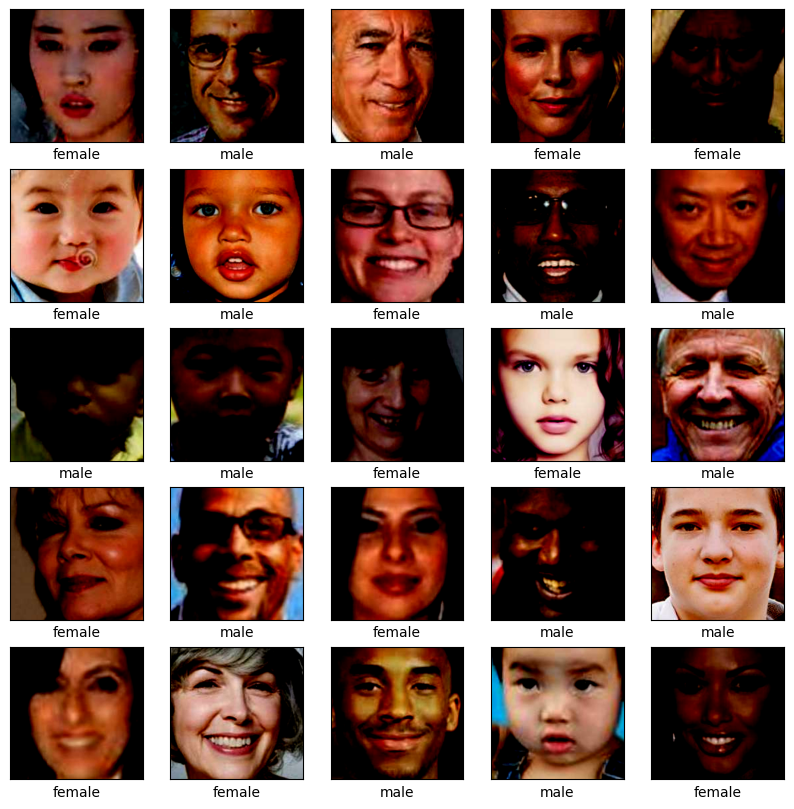

In [11]:
#Plot Example Images to ensure everything looks correct

class_names = ['female','male']
random_indices = random.sample(range(len(train_images)), 25) 

plt.figure(figsize=(10,10))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])  # Use the random index
    plt.xlabel(class_names[train_labels[idx]])  # Use the random index
plt.show()

In [12]:
#Set Base Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the first few layers
for layer in base_model.layers[:150]:  # Experiment with the number of layers to freeze
    layer.trainable = False

# Add layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, kernel_regularizer='l2')  # Add L2 regularization
softmax_layer = tf.keras.layers.Softmax()

# Create the complete model
model = tf.keras.Sequential(
    [base_model, global_average_layer, prediction_layer, softmax_layer]
)

In [13]:
#Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))

Epoch 1/5


2024-11-07 12:18:59.160528: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


593/593 [==============================] - 159s 266ms/step - loss: 0.4207 - accuracy: 0.8391 - val_loss: 0.5404 - val_accuracy: 0.8014
Epoch 2/5
593/593 [==============================] - 159s 269ms/step - loss: 0.2936 - accuracy: 0.8833 - val_loss: 0.3347 - val_accuracy: 0.8739
Epoch 3/5
593/593 [==============================] - 154s 260ms/step - loss: 0.2521 - accuracy: 0.9038 - val_loss: 0.3235 - val_accuracy: 0.8762
Epoch 4/5
593/593 [==============================] - 183s 309ms/step - loss: 0.2271 - accuracy: 0.9154 - val_loss: 0.3290 - val_accuracy: 0.8788
Epoch 5/5
593/593 [==============================] - 160s 269ms/step - loss: 0.1973 - accuracy: 0.9303 - val_loss: 0.3613 - val_accuracy: 0.8680


149/149 - 30s - loss: 0.3613 - accuracy: 0.8680 - 30s/epoch - 203ms/step


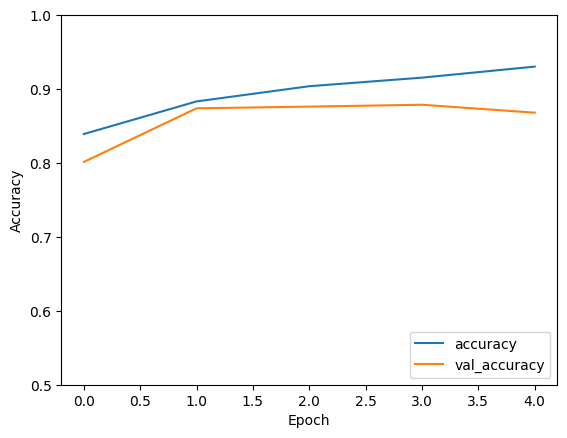

In [14]:
#Plot Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [15]:
#Save the model for use in Ace algorithms
model.save("models/gender_classification.h5")

#Get summary so I can feed in bottleneck layer and input layers into custom_wrapper later
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 2,261,827
Trainable params: 416,643
Non-trainable params: 1,845,184
_________________________________________________________________


# Running LIME and SHAP Tests

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
explanation = explainer.explain_instance(test_images[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step


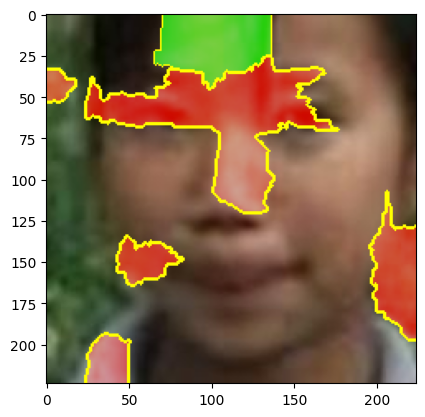

In [18]:
#see the 'pros and cons' (pros in green, cons in red)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [19]:
explanation = explainer.explain_instance(test_images[1000], model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 70ms/step


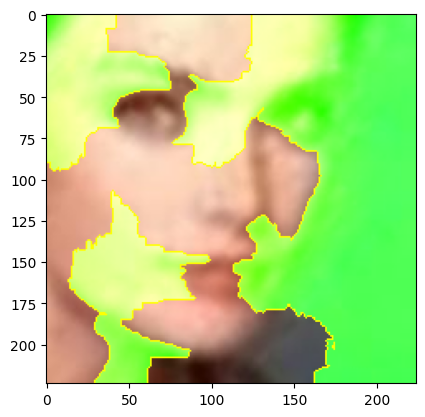

In [20]:
#see the 'pros and cons' (pros in green, cons in red)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:51, 51.59s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


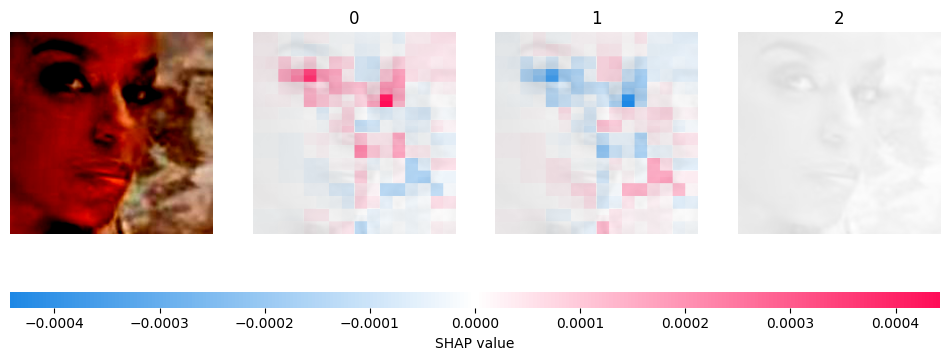

In [21]:
#Running SHAP example from here: https://medium.com/@oveis/easy-guide-using-shap-algorithm-to-explain-cnn-classification-of-sar-images-mstar-database-8138657585c8

def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(32,32)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[600]
shap_values_ = explainer( test_images[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=[0,1,2])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:50, 50.28s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


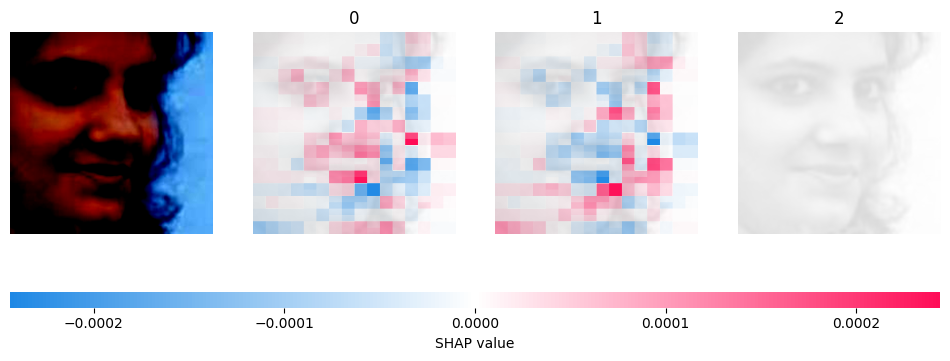

In [22]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(32,32)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[333]
shap_values_ = explainer( test_images[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=[0,1,2])